In [3]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [4]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# set device
device = torch.device("cpu")
print("| using device:", device)

| using device: cpu


In [5]:
# hyperparams
bsz = 10

## Data

In [6]:
from datasets import load_dataset
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

# Load MNIST from Hugging Face
dataset = load_dataset("mnist")

# Define a transform to convert PIL images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to Tensor (scales 0-1)
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize like torchvision MNIST
])

# Convert images and labels
train_images = torch.stack([transform(img) for img in dataset["train"]["image"]])
train_labels = torch.tensor(dataset["train"]["label"], dtype=torch.long)
test_images = torch.stack([transform(img) for img in dataset["test"]["image"]])
test_labels = torch.tensor(dataset["test"]["label"], dtype=torch.long)

# Create dataset
train_data = TensorDataset(train_images, train_labels)
test_data = TensorDataset(test_images, test_labels)

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

# Check shape
print(f"Train data shape: {train_images.shape}")  # Should be [60000, 1, 28, 28]
print(f"Test data shape: {test_images.shape}")    # Should be [10000, 1, 28, 28]



Train data shape: torch.Size([60000, 1, 28, 28])
Test data shape: torch.Size([10000, 1, 28, 28])


In [7]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)

iid:  tensor([58., 59., 61., 56., 53., 66., 66., 65., 62., 54.])


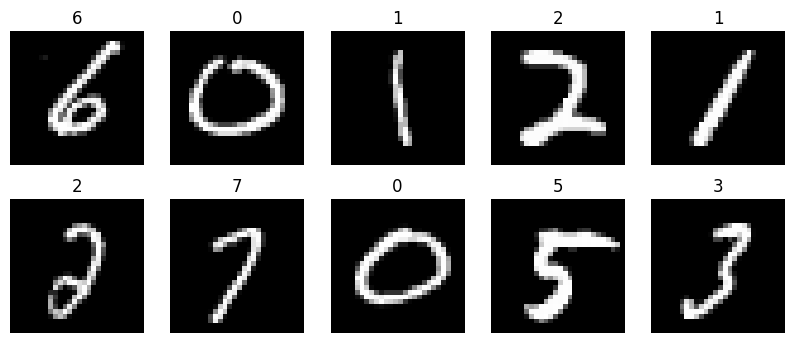

In [8]:
# iid
label_dist = torch.zeros(10)
for (x,y) in iid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y, num_classes=10), dim=0)
print("iid: ", label_dist)
view_10(x,y)

non-iid:  tensor([300.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.,   0.])


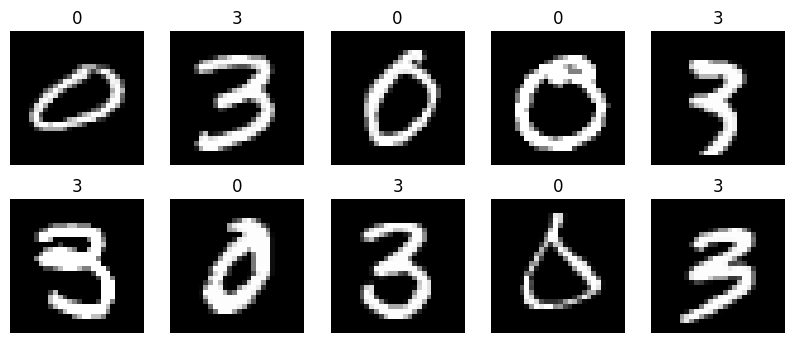

In [9]:
# non-iid
label_dist = torch.zeros(10)
for (x,y) in noniid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y,num_classes=10), dim=0)
print("non-iid: ", label_dist)
view_10(x,y)

## Models

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define function to calculate number of parameters
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Define Fully Connected Neural Network (MLP)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.out = nn.Linear(200, 10)

    def forward(self, x):
        x = x.flatten(1)  # Flatten input from [B, 1, 28, 28] to [B, 784]
        x = F.relu(self.fc1(x))  # Hidden layer 1
        x = F.relu(self.fc2(x))  # Hidden layer 2
        x = self.out(x)  # Output layer
        return x

# Create model and print details
model = MLP()
print(model)
print(f"Total Trainable Parameters: {num_params(model)}")


MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
Total Trainable Parameters: 199210


In [11]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())
print(num_params(CNN()))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
582026


## Training

In [12]:
criterion = nn.CrossEntropyLoss()

def validate(model):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [13]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

In [14]:
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)
        
        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

    return np.array(round_accuracy)


 ## MLP experiments

In [15]:
mlp = MLP()
print(mlp)
print("total params: ", num_params(mlp))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
total params:  199210


In [16]:
# MLP - iid - m=10 experiment
mlp_iid_m10 = copy.deepcopy(mlp)
acc_mlp_iid_m10 = fed_avg_experiment(mlp_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                #  max_rounds=100,
                                 max_rounds=10,
                                 filename='./acc_mlp_iid_m10')
print(acc_mlp_iid_m10)
np.save('./acc_mlp_iid_m10.npy', acc_mlp_iid_m10)

starting round 0
clients:  [26 86  2 55 75 93 16 73 54 95]
round 0, starting client 1/10, id: 26
round 0, starting client 2/10, id: 86
round 0, starting client 3/10, id: 2
round 0, starting client 4/10, id: 55
round 0, starting client 5/10, id: 75
round 0, starting client 6/10, id: 93
round 0, starting client 7/10, id: 16
round 0, starting client 8/10, id: 73
round 0, starting client 9/10, id: 54
round 0, starting client 10/10, id: 95
round 0, validation acc: 0.8324
starting round 1
clients:  [18 29 64 92 72 87  5 15 12 17]
round 1, starting client 1/10, id: 18
round 1, starting client 2/10, id: 29
round 1, starting client 3/10, id: 64
round 1, starting client 4/10, id: 92
round 1, starting client 5/10, id: 72
round 1, starting client 6/10, id: 87
round 1, starting client 7/10, id: 5
round 1, starting client 8/10, id: 15
round 1, starting client 9/10, id: 12
round 1, starting client 10/10, id: 17
round 1, validation acc: 0.8859
starting round 2
clients:  [42 96 58 14 72  4 47 64 57 63]

In [17]:
# MLP - iid - m=50 experiment
mlp_iid_m50 = copy.deepcopy(mlp)
acc_mlp_iid_m50 = fed_avg_experiment(mlp_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                #  max_rounds=100,
                                max_rounds=10,
                                 filename='./acc_mlp_iid_m50')
print(acc_mlp_iid_m50)
np.save('./acc_mlp_iid_m50.npy', acc_mlp_iid_m50)

starting round 0
clients:  [81 50 91 56 75 17 40 85 71 35 46 49 48  2 43 30 65 62  6 61  9 20 10 83
 70 27 58 36 74  5  0 22 31  4 23 32 19 13 94 38 41 33 44 90 76 54 34 45
 26 52]
round 0, starting client 1/50, id: 81
round 0, starting client 2/50, id: 50
round 0, starting client 3/50, id: 91
round 0, starting client 4/50, id: 56
round 0, starting client 5/50, id: 75
round 0, starting client 6/50, id: 17
round 0, starting client 7/50, id: 40
round 0, starting client 8/50, id: 85
round 0, starting client 9/50, id: 71
round 0, starting client 10/50, id: 35
round 0, starting client 11/50, id: 46
round 0, starting client 12/50, id: 49
round 0, starting client 13/50, id: 48
round 0, starting client 14/50, id: 2
round 0, starting client 15/50, id: 43
round 0, starting client 16/50, id: 30
round 0, starting client 17/50, id: 65
round 0, starting client 18/50, id: 62
round 0, starting client 19/50, id: 6
round 0, starting client 20/50, id: 61
round 0, starting client 21/50, id: 9
round 0, sta

In [18]:
# MLP - non-iid - m=10 experiment
mlp_noniid_m10 = copy.deepcopy(mlp)
acc_mlp_noniid_m10 = fed_avg_experiment(mlp_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                #  max_rounds=300,
                                max_rounds=10,
                                 filename = './acc_mlp_noniid_m10')
print(acc_mlp_noniid_m10)
np.save('./acc_mlp_noniid_m10.npy', acc_mlp_noniid_m10)

starting round 0
clients:  [66 90 96 14 51 12 19 71 74 69]
round 0, starting client 1/10, id: 66
round 0, starting client 2/10, id: 90
round 0, starting client 3/10, id: 96
round 0, starting client 4/10, id: 14
round 0, starting client 5/10, id: 51
round 0, starting client 6/10, id: 12
round 0, starting client 7/10, id: 19
round 0, starting client 8/10, id: 71
round 0, starting client 9/10, id: 74
round 0, starting client 10/10, id: 69
round 0, validation acc: 0.2586
starting round 1
clients:  [39 21 60 83 79 76 19 53 71 25]
round 1, starting client 1/10, id: 39
round 1, starting client 2/10, id: 21
round 1, starting client 3/10, id: 60
round 1, starting client 4/10, id: 83
round 1, starting client 5/10, id: 79
round 1, starting client 6/10, id: 76
round 1, starting client 7/10, id: 19
round 1, starting client 8/10, id: 53
round 1, starting client 9/10, id: 71
round 1, starting client 10/10, id: 25
round 1, validation acc: 0.3817
starting round 2
clients:  [45 99 21 76  2 51 66 14 80 9

In [19]:
# MLP - noniid - m=50 experiment
mlp_noniid_m50 = copy.deepcopy(mlp)
acc_mlp_noniid_m50 = fed_avg_experiment(mlp_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                #  max_rounds=300,
                                max_rounds=10,
                                 filename='./acc_mlp_noniid_m50')
print(acc_mlp_noniid_m50)
np.save('./acc_mlp_noniid_m50.npy', acc_mlp_noniid_m50)

starting round 0
clients:  [ 4 73 24 57 23 70 16 97 32 42 58 20 38 72 52  2 48 30 12 34 54 90 60 80
 29 83 22 15 95 85 14 33 18 53 11 65 86 88 96 67  9 69 31 27  5 45 87 39
 36 78]
round 0, starting client 1/50, id: 4
round 0, starting client 2/50, id: 73
round 0, starting client 3/50, id: 24
round 0, starting client 4/50, id: 57
round 0, starting client 5/50, id: 23
round 0, starting client 6/50, id: 70
round 0, starting client 7/50, id: 16
round 0, starting client 8/50, id: 97
round 0, starting client 9/50, id: 32
round 0, starting client 10/50, id: 42
round 0, starting client 11/50, id: 58
round 0, starting client 12/50, id: 20
round 0, starting client 13/50, id: 38
round 0, starting client 14/50, id: 72
round 0, starting client 15/50, id: 52
round 0, starting client 16/50, id: 2
round 0, starting client 17/50, id: 48
round 0, starting client 18/50, id: 30
round 0, starting client 19/50, id: 12
round 0, starting client 20/50, id: 34
round 0, starting client 21/50, id: 54
round 0, st

## CNN Experiments

In [20]:
cnn = CNN()
print(cnn)
print("total params: ", num_params(cnn))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
total params:  582026


In [21]:
# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                #  max_rounds=100,
                                max_rounds=10,
                                 filename='./acc_cnn_iid_m10')
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

starting round 0
clients:  [18 45 38 21 10 41 59 96 60 72]
round 0, starting client 1/10, id: 18
round 0, starting client 2/10, id: 45
round 0, starting client 3/10, id: 38
round 0, starting client 4/10, id: 21
round 0, starting client 5/10, id: 10
round 0, starting client 6/10, id: 41
round 0, starting client 7/10, id: 59
round 0, starting client 8/10, id: 96
round 0, starting client 9/10, id: 60
round 0, starting client 10/10, id: 72
round 0, validation acc: 0.9095
starting round 1
clients:  [28 95 67 82 33 61 79 16 72  7]
round 1, starting client 1/10, id: 28
round 1, starting client 2/10, id: 95
round 1, starting client 3/10, id: 67
round 1, starting client 4/10, id: 82
round 1, starting client 5/10, id: 33
round 1, starting client 6/10, id: 61
round 1, starting client 7/10, id: 79
round 1, starting client 8/10, id: 16
round 1, starting client 9/10, id: 72
round 1, starting client 10/10, id: 7
round 1, validation acc: 0.931
starting round 2
clients:  [ 4 26  1 31 86  3 34 15  8 87]

In [22]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                #  max_rounds=100,
                                max_rounds=10,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)

starting round 0
clients:  [53 27 10  3 52 83 39 43  7 44 58 61 93  4 32 16 65 40 64  8 66 34 84 89
 59 72 96 57 70  6 56  5 68 11 51 15 94 48 25 17 86  1 29 42 75 19 62 67
 14 50]
round 0, starting client 1/50, id: 53
round 0, starting client 2/50, id: 27
round 0, starting client 3/50, id: 10
round 0, starting client 4/50, id: 3
round 0, starting client 5/50, id: 52
round 0, starting client 6/50, id: 83
round 0, starting client 7/50, id: 39
round 0, starting client 8/50, id: 43
round 0, starting client 9/50, id: 7
round 0, starting client 10/50, id: 44
round 0, starting client 11/50, id: 58
round 0, starting client 12/50, id: 61
round 0, starting client 13/50, id: 93
round 0, starting client 14/50, id: 4
round 0, starting client 15/50, id: 32
round 0, starting client 16/50, id: 16
round 0, starting client 17/50, id: 65
round 0, starting client 18/50, id: 40
round 0, starting client 19/50, id: 64
round 0, starting client 20/50, id: 8
round 0, starting client 21/50, id: 66
round 0, star

In [23]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                #  max_rounds=200,
                                max_rounds=10,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)

starting round 0
clients:  [ 9  4 97 84  2 36 20  5 79  0]
round 0, starting client 1/10, id: 9
round 0, starting client 2/10, id: 4
round 0, starting client 3/10, id: 97
round 0, starting client 4/10, id: 84
round 0, starting client 5/10, id: 2
round 0, starting client 6/10, id: 36
round 0, starting client 7/10, id: 20
round 0, starting client 8/10, id: 5
round 0, starting client 9/10, id: 79
round 0, starting client 10/10, id: 0
round 0, validation acc: 0.3019
starting round 1
clients:  [58 47 29 99  6 69  7 53 81 45]
round 1, starting client 1/10, id: 58
round 1, starting client 2/10, id: 47
round 1, starting client 3/10, id: 29
round 1, starting client 4/10, id: 99
round 1, starting client 5/10, id: 6
round 1, starting client 6/10, id: 69
round 1, starting client 7/10, id: 7
round 1, starting client 8/10, id: 53
round 1, starting client 9/10, id: 81
round 1, starting client 10/10, id: 45
round 1, validation acc: 0.3863
starting round 2
clients:  [55 94  0 82 81 83 66 39 54  4]
roun

In [24]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                #  max_rounds=100,
                                max_rounds=10,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)

starting round 0
clients:  [58 10  8  7 26  2  5 49  4 84 82 24 57 77 21 32 72 86 52 55 74 13 79 39
 29 44 53  9 70 94 48 76  1 71  3 27 30 68 16 88 69 93 43 80 46 34 54 61
 65 96]
round 0, starting client 1/50, id: 58
round 0, starting client 2/50, id: 10
round 0, starting client 3/50, id: 8
round 0, starting client 4/50, id: 7
round 0, starting client 5/50, id: 26
round 0, starting client 6/50, id: 2
round 0, starting client 7/50, id: 5
round 0, starting client 8/50, id: 49
round 0, starting client 9/50, id: 4
round 0, starting client 10/50, id: 84
round 0, starting client 11/50, id: 82
round 0, starting client 12/50, id: 24
round 0, starting client 13/50, id: 57
round 0, starting client 14/50, id: 77
round 0, starting client 15/50, id: 21
round 0, starting client 16/50, id: 32
round 0, starting client 17/50, id: 72
round 0, starting client 18/50, id: 86
round 0, starting client 19/50, id: 52
round 0, starting client 20/50, id: 55
round 0, starting client 21/50, id: 74
round 0, start

In [25]:
# view_10(x_debug[:10].to(cpu), torch.argmax(model(x_debug),dim=1)[:10].to(cpu))

# m = CNN().to(cuda)
# m.train()
# lr = 0.01
# opt = torch.optim.SGD(m.parameters(), lr)

# for epoch in range(5):
#     for (t, (x,y)) in enumerate(train_loader):
#         x = x.to(cuda)
#         y = y.to(cuda)
#         opt.zero_grad()
#         out = m(x)
#         loss = criterion(out, y)
#         loss.backward()
#         opt.step()

#         if (t%100 == 0):
#             print("epoch {}, step {}, loss: {}".format(epoch, t, loss))

#     print("running validation")
#     acc = validate(m)
#     print("epoch {} validation acc: {}".format(epoch, acc))